In [ ]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

In [ ]:
# load the dataset
(X_train,_), (X_test,_) = tf.keras.datasets.mnist.load_data()

# set the originial images as targets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, X_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, X_test))

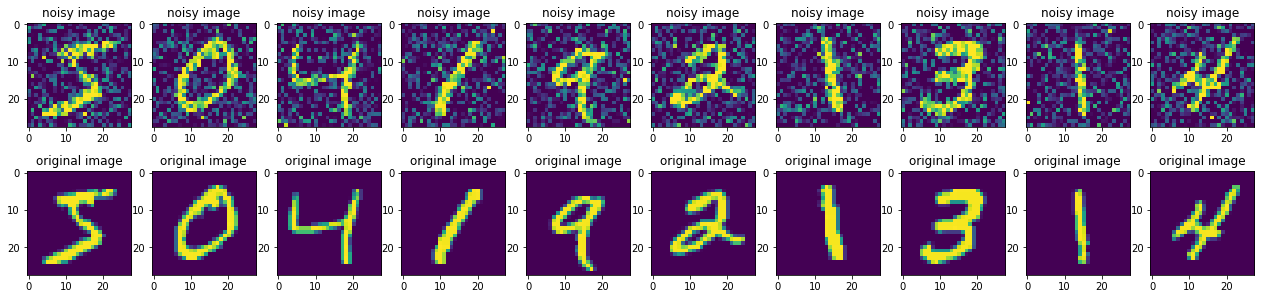

In [3]:
# add an empty dimension and scale the images to values between 0 and 1
normalize = lambda x: tf.cast(tf.expand_dims(x, -1), tf.float32) / 255.

# add noise to the image   
add_noise = lambda x, e: tf.clip_by_value(x + e * tf.random.normal(mean=0., stddev=1., shape=x.shape),
                                          clip_value_min=0.,
                                          clip_value_max=1.)

# apply functions to the training examples
original = normalize(X_train)
noisy = add_noise(original, 0.3)

# plot the original and noisy images
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(22,5))

for i in range(0, 10):
    ax[0,i].imshow(noisy[i])
    ax[0,i].set(title='noisy image')
    ax[1,i].imshow(original[i])
    ax[1,i].set(title='original image')
    
plt.show();

In [ ]:
def prepare_data(ds, noise_level=0.3, batch_size=32):
    # apply lambda functions
    ds = ds.map(lambda x,t: (normalize(x), normalize(t)))
    ds = ds.map(lambda x,t: (add_noise(x, noise_level), t))
    
    # shuffle, batch, prefetch
    ds = ds.cache().shuffle(1028).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return ds

# prepare the dataset
train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)